In [ ]:
import tensorflow as tf
import numpy as np
from google.cloud import storage
import matplotlib.pyplot as plt
import random
import pandas as pd
from io import BytesIO
from sklearn.model_selection import train_test_split
from typing import List, Tuple
import vertexai
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from google import genai # Importar genai aquí
import os
from PIL import Image
import io
import csv
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.neighbors import NearestNeighbors
from typing import Sequence
import time
import asyncio
from sklearn.metrics.pairwise import cosine_distances
from IPython.display import HTML, Markdown, display
from google import genai
import PIL.Image
from google.genai import types

In [ ]:
# CORRER ESTA CELDA TANTO REFUGE COMO MHIST
PROJECT_ID = "[your-project-id]"
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

if not client.vertexai:
    print(f"Using Gemini Developer API.")
elif client._api_client.project:
    print(
        f"Using Vertex AI with project: {client._api_client.project} in location: {client._api_client.location}"
    )
elif client._api_client.api_key:
    print(
        f"Using Vertex AI in express mode with API key: {client._api_client.api_key[:5]}...{client._api_client.api_key[-5:]}"
    )

Using Vertex AI with project: llms-for-biomed in location: us-central1


In [ ]:
#MODEL_ID = "gemini-2.0-flash"
#MODEL_ID = "gemini-1.5-pro"
#MODEL_ID = "gemini-2.5-flash-preview-04-17"
MODEL_ID = "gemini-2.0-flash-lite-001"
#MODEL_ID = "gemini-2.5-pro-exp-03-25"
# response = client.models.generate_content(
#     model=MODEL_ID, contents="What's the largest planet in our solar system?"
# )

# display(Markdown(response.text))

## **MHIST experiments**

Este fragmento de código se conecta a un bucket de Google Cloud Storage, descarga el CSV de anotaciones, lo carga en un DataFrame de pandas y crea una columna binaria y que vale 1 cuando la etiqueta es “SSA” y 0 en caso contrario.

In [ ]:
# 1) Parámetros de tu bucket
BUCKET_NAME    = "datasets_biomed_llm"
PREFIX_IMAGES  = "MHIST/"         # carpeta en el bucket que contiene las imágenes
PREFIX_CSV     = "MHIST/annotations_train_val_test.csv" # ruta dentro del bucket

# 2) Inicializa el cliente de GCS
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

# 3) Descarga y carga el CSV de anotaciones
blob_csv = bucket.blob(PREFIX_CSV)
data_csv = blob_csv.download_as_bytes()
df = pd.read_csv(io.BytesIO(data_csv))

# 4) Procesa la etiqueta binaria
df["y"] = (df["Majority Vote Label"] == "SSA").astype(int)

In [ ]:
df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aaa.png,SSA,6,train,1
1,MHIST_aab.png,HP,0,train,0
2,MHIST_aac.png,SSA,5,train,1
3,MHIST_aae.png,HP,1,train,0
4,MHIST_aaf.png,SSA,5,train,1


In [ ]:
# DataFrame de entrenamiento
train_df = df[df["Partition"] == "train"].reset_index(drop=True)

# DataFrame de validación
val_df = df[df["Partition"] == "val"].reset_index(drop=True)

# DataFrame de prueba
test_df  = df[df["Partition"] == "test"].reset_index(drop=True)

In [ ]:
train_df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aaa.png,SSA,6,train,1
1,MHIST_aab.png,HP,0,train,0
2,MHIST_aac.png,SSA,5,train,1
3,MHIST_aae.png,HP,1,train,0
4,MHIST_aaf.png,SSA,5,train,1


In [ ]:
val_df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aai.png,HP,3,val,0
1,MHIST_aam.png,HP,0,val,0
2,MHIST_aas.png,SSA,4,val,1
3,MHIST_aat.png,HP,0,val,0
4,MHIST_aaw.png,HP,0,val,0


In [ ]:
test_df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aag.png,HP,2,test,0
1,MHIST_aah.png,HP,2,test,0
2,MHIST_aaq.png,SSA,5,test,1
3,MHIST_aar.png,HP,0,test,0
4,MHIST_aay.png,HP,1,test,0


(**Esta parte tarda 9 minutos**)

In [ ]:
#5) Itera sobre el dataframe, descarga cada imagen y conviértela a array
X_list, y_list = [], []
for _, row in df.iterrows():
    img_blob = bucket.blob(PREFIX_IMAGES + row["Image Name"])
    img_bytes = img_blob.download_as_bytes()
    with Image.open(io.BytesIO(img_bytes)) as im: # PIL necesita una representación de la imagen en formato de bytes
        im = im.convert("RGB").resize((224,224))
        arr = np.array(im)
    X_list.append(arr)
    y_list.append(row["y"])

# 6) Ensambla los arrays finales
X = np.stack(X_list, axis=0)    # (N,224,224,3)
y = np.array(y_list, dtype=int) # (N,)

print(f"Cargadas {len(X)} imágenes. Distribución de etiquetas: {np.bincount(y)}")

Cargadas 3152 imágenes. Distribución de etiquetas: [2162  990]


In [ ]:
# Como X (arreglos de numpy) y y (etiquetas) son las imágenes y etiquetas
# y están alineados con el dataframe, entonces
# Las separamos en entrenameinto, validación y prueba

# 1) Extrae la columna "Partition" como lista
partitions = df["Partition"].values  # Tiene el mismo orden que X, y

# 3) Filtra por train o test
X_train = X[partitions == "train"]
y_train = y[partitions == "train"]

X_val = X[partitions == "val"]
y_val = y[partitions == "val"]

X_test = X[partitions == "test"]
y_test = y[partitions == "test"]

# 4) Confirmación
print("Train:", X_train.shape, np.bincount(y_train))
print("Val:", X_val.shape, np.bincount(y_val))
print("Test: ", X_test.shape,  np.bincount(y_test))

Train: (1740, 224, 224, 3) [1236  504]
Val: (435, 224, 224, 3) [309 126]
Test:  (977, 224, 224, 3) [617 360]


### **Funciones que se usan durante los experimentos:**

In [ ]:
# FUNCIÓN PARA CREAR LA LISTA DE MUESTRAS QUE SE LE VAN A DAR AL MODELO DE GEMINI COMO CONTEXTO

def init_examples_from_dataset(
        X: Sequence[np.ndarray],
        y: Sequence[int],
        n_pos: int = 3,
        n_neg: int = 3,
        seed: int | None = None
) -> list[tuple[np.ndarray, int]]:
    """
    Rellena la lista global EXAMPLES con `n_pos` ejemplos precancerosos (y==1)
    y `n_neg` normales (y==0) tomados al azar de X / y.

    Parámetros
    ----------
    X : iterable de np.ndarray
        Imágenes RGB (shape H×W×3, rango 0‑255).
    y : iterable de int
        Etiquetas 1 = SSA, 0 = HP(normal).
    n_pos, n_neg : int
        Cantidad de ejemplos positivos y negativos a guardar.
    seed : int | None
        Fija la semilla de `random` para reproducibilidad.
    """
    if seed is not None:
        random.seed(seed)

    # Creo listas de indices de etiquetas positivas y negativas
    pos_idx = [i for i, lbl in enumerate(y) if lbl == 1]
    neg_idx = [i for i, lbl in enumerate(y) if lbl == 0]

    if len(pos_idx) < n_pos or len(neg_idx) < n_neg:
        raise ValueError("No hay suficientes ejemplos positivos/negativos "
                         "en el dataset para la cantidad solicitada.")


    # Barajar sí funciona o no? Corroborar
    chosen = random.sample(pos_idx, n_pos) + random.sample(neg_idx, n_neg)
    #print(f"Chosen: {chosen}")
    #random.shuffle(chosen)

    EXAMPLES = []
    for i in chosen:
        EXAMPLES.append((X[i], int(y[i])))

    print(f"✅ EXAMPLES inicializado con {len(EXAMPLES)} imágenes "
          f"({n_pos} SSA, {n_neg} HP).")
    return EXAMPLES

EXAMPLES = init_examples_from_dataset(X_train, y_train, n_pos=3, n_neg=3, seed=42)

✅ EXAMPLES inicializado con 6 imágenes (3 SSA, 3 HP).


In [ ]:
async def ask_gemini_polyp_fewshot_async(
    image: np.ndarray,
    semaphore: asyncio.Semaphore,
    request_timeout: int = 60
) -> dict:
    """
    Versión async de ask_gemini_polyp_fewshot.
    Usa `semaphore` para limitar concurrencia y `await asyncio.to_thread` para no bloquear.
    """
    if not EXAMPLES:
        raise ValueError(
            "EXAMPLES está vacío. Usa set_examples(...) o init_examples_from_dataset(...)"
        )

    # 1) Convierte NumPy a PIL.Image (igual que antes)
    img_pil = (
        PIL.Image.fromarray((image * 255).astype(np.uint8))
        if image.max() <= 1
        else PIL.Image.fromarray(image.astype(np.uint8))
    )

    # 2) Construye la lista contents con few-shot examples (idéntico)
    text1 = types.Part.from_text(text="""Analyze the query image based on the following steps:

    1.  Carefully examine the provided example images and their corresponding labels ('SSA' or 'HP').
    2.  Identify key features in the example images associated with each class (SSA and HP), such as crypt distortion,
    goblet cell mucin depletion, branching crypts, and serrated architecture.
    3.  Analyze the query image, looking for the same key features identified in the example images.
    4.  Based on the presence or absence of key features and the example images, classify the query image as either 'SSA' or 'HP'.

    Here are the example images with corresponding labels using
    the following format: <image file> label: <image label>

    EXAMPLES:
    """)
    text2 = types.Part.from_text(text="""  QUERY IMAGE:""")
    text3 = types.Part.from_text(text="""  Based on the examples provided, what is the class of the query image?""")
    si_text1 = """You are an expert medical AI assistant trained in histopathology.
    Your task is to analyze microscopic images of colon tissue and classify them as either
    'SSA' (Sessile Serrated Adenoma) or 'HP' (Healthy Polyp).
    HPs are typically benign, while sessile serrated adenomas (SSAs) are precancerous
    lesions that can turn into cancer if left untreated and require sooner follow-up examinations."""

    contents: list[object] = []
    contents.append(text1)
    for idx, (ex_img, label) in enumerate(EXAMPLES, 1):
        ex_pil = (
            PIL.Image.fromarray((ex_img * 255).astype(np.uint8))
            if ex_img.max() <= 1
            else PIL.Image.fromarray(ex_img.astype(np.uint8))
        )
        contents.append(ex_pil)
        contents.append(f" label : {'SSA' if label == 1 else 'HP'} \n")

    # Añade la imagen candidata
    contents.append(text2)
    contents.append(img_pil)
    contents.append(text3)

    generate_content_config = types.GenerateContentConfig(
    system_instruction=[types.Part.from_text(text=si_text1)])

    # 3) Llamada bloqueante al API dentro de to_thread + timeout, protegida por semaphore
    async with semaphore:
        try:
            response = await asyncio.wait_for(
                asyncio.to_thread(
                    lambda: client.models.generate_content(
                        model=MODEL_ID,
                        contents=contents
                    )
                ),
                timeout=request_timeout
            )

        except asyncio.TimeoutError as e:
            print(f"⚠️ Timeout tras {request_timeout}s en few-shot image")
            raise
        except Exception as e:
            print(f"⚠️ Error few-shot Gemini: {e}")
            raise


    # 4) Post-procesado de la respuesta (igual que antes)
    raw = response.text.strip().lower()
    segment = raw[-20:]
    if "classification: ssa" in segment:
      pred = 1
    elif "classification: hp" in segment:
      pred = 0
    else:
      pred = -1
    # raw = response.text.strip().lower()
    # pred = 1 if "ssa" in raw[len(raw)-6:] else 0

    return {
        "prompt":si_text1,#si_text1,#instruction,
        "raw_response": raw,
        "predicted_class": pred,
        "n_examples": len(EXAMPLES)
    }

In [ ]:
raw = 'image is ssa.**'
raw[len(raw)-6:]

'ssa.**'

In [ ]:
raw = 'image is ssa**.'
raw[len(raw)-6:]

'ssa**.'

In [ ]:
raw = 'image is ssa**'
raw[len(raw)-5:]

'ssa**'

In [ ]:
'ssa**' in 'image is ssa**.'

True

In [ ]:
# create a script to evaluate the function ask_gemini_polyp_fewshot_async for some images
# choose 10 random samples from X
indices = np.random.choice(X.shape[0], size=10, replace=False)
X_samples = X[indices]
# for each sample
for image in X_samples:
    print('===================================COMIENZO=============================================')
    # evaluate the function
    result = await ask_gemini_polyp_fewshot_async(image=image, semaphore=asyncio.Semaphore(1))
    # print the result
    print('Respuesta de gemini:',result['raw_response'])
    print('Clase predicha:', result['predicted_class'])
    print('====================================FIN=============================================')

===================================COMIENZO=============================================
Respuesta de gemini: here's the analysis of the query image:

1.  **example image analysis:**
    *   **ssa (serrated sessile adenoma):** key features include:
        *   crypt distortion (irregular shapes, often branching or dilated)
        *   serrated architecture (saw-tooth appearance)
        *   goblet cell mucin depletion (fewer mucin-filled cells)
    *   **hp (hyperplastic polyp):** key features include:
        *   rounded, regular crypts
        *   often with a "star-shaped" lumen appearance
        *   lack of significant distortion or branching

2.  **query image analysis:**
    *   the query image exhibits a significant crypt distortion, with irregular, branching crypts.
    *   there is a serrated architecture in the upper part.

3.  **classification:**
    *   based on the features observed, the query image is best classified as **ssa**.
Clase predicha: 1
========================

In [ ]:
def evaluate_polyp_classifier(y_true, y_pred, probas=None):
    """
    Evaluates a polyp classifier.
    """
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
    }

    if probas is not None:
        try:
            metrics["AUC"] = roc_auc_score(y_true, probas)
        except ValueError:
            metrics["AUC"] = "Undefined (only one class present in y_true)"

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    return metrics, cm, report

In [ ]:
def stratified_sample_from_mhist(X, y, fraction: float):
    """
    Extracts a stratified sample from the MHIST dataset based on the given fraction.

    Args:
        X (np.ndarray): Array of images.
        y (np.ndarray): Array of labels.
        fraction (float): Fraction of dataset to use for testing (0 < fraction <= 1).

    Returns:
        Tuple[np.ndarray, np.ndarray]: Sampled images and labels.
    """
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")

    X_sampled, _, y_sampled, _ = train_test_split(
        X, y, train_size=fraction, stratify=y, random_state=42
    )
    return X_sampled, y_sampled

In [ ]:
async def evaluate_classifier_on_sample(
    X, y, fraction: float, classifier_func,
    semaphore:asyncio.Semaphore, verbose: bool = False
) -> dict:
    """
    Evaluates a classifier function on a stratified sample of the MHIST dataset.

    Args:
        X (np.ndarray): Full dataset images.
        y (np.ndarray): Full dataset labels.
        fraction (float): Fraction of the dataset to use.
        classifier_func (callable): Function(image: np.ndarray) -> int or dict with 'predicted_class'.
        api_key (str): OpenAI API key to pass into the classifier function.
        verbose (bool): Whether to print detailed logs.

    Returns:
        dict: metrics, confusion matrix, and classification report.
    """
    import time

    if 0 < fraction < 1:
        X_sampled, y_sampled = stratified_sample_from_mhist(X, y, fraction)
    elif fraction == 1.0:
        X_sampled, y_sampled = X, y
    else:
        raise ValueError("Fraction must be between 0 and 1 (inclusive of 1.0).")

    start_time = time.time()

        # 1) Crea todas las tareas de clasificación (se harán concurrentes hasta el límite del semáforo)
    tasks = [
        asyncio.create_task(classifier_func(image=image, semaphore=semaphore))
        for image in X_sampled
    ]

    # 2) Espera a que terminen todas
    results = await asyncio.gather(*tasks, return_exceptions=True)

    # 2) Cuenta cuántos errores reales hubo
    # Total de imágenes que intentaste procesar
    n_total = len(results)
    # Cuántas fallaron (excepciones reales)
    n_errors = sum(1 for r in results if isinstance(r, Exception))
    # Cuántas se evaluaron con éxito
    n_success = n_total - n_errors

    print(f"📊 Total: {n_total}, ✅ Éxitos: {n_success}, ❌ Fallos: {n_errors}")

    if verbose and n_errors>0:
      print(f"❌ Aviso: {n_errors} imágenes fallaron en la clasificación.")

    # 3) Procesa los resultados—solo guardamos los exitosos
    y_preds       = []
    y_true_valid  = []
    for idx, res in enumerate(results):
        if isinstance(res, Exception):
            if verbose:
                print(f"❌ Error processing image {idx+1}: {res}")
            continue
        # Alinea y_true con cada res válido
        y_preds.append(res["predicted_class"])
        y_true_valid.append(y_sampled[idx])


    duration = time.time() - start_time
    if verbose:
        print(f"✅ Evaluation completed in {duration:.2f} seconds")

    # Ahora calculamos métricas solo sobre los casos válidos
    metrics, cm, report = evaluate_polyp_classifier(y_true_valid, y_preds)

    return {
        "metrics": metrics,
        "confusion_matrix": cm,
        "report": report,
        "y_true": y_true_valid,
        "y_pred": y_preds
    }

**Resumen de las funciones:**
  1. init_examples_from_dataset (crea las muestras de contexto).
  2. ask_gemini_polyp_fewshot_async (clasifica una imagen usando Gemini con ejemplos few-shot, se apoya en un resultado de 1).
  3. evaluate_polyp_classifier (arroja métricas, matriz de confusión, reporte de un clasificador).
  4. stratified_sample_from_mhist (extrae una muestra estratificada y etiquetas).
  5. evaluate_classifier_on_sample (evalúa un clasificador sobre una muestra estratificada de MHIST, usa a 4, usa a 3 y llama a 1 en el experimento).

## **INICIO EXPERIMENTOS MHIST**

### ***Few-shot al azar en varias corridas con distintos tamaños de shots: 8, 16 y 32***

In [ ]:
# Evaluación few-shot en múltiples corridas

# Descripción:
# Este bloque repite N veces la evaluación few-shot para varios modelos y tamaños de “shots”,
# calcula Accuracy, Precision, Recall, F1 (y AUC si está disponible) en cada corrida,
# y devuelve un DataFrame con una fila por (run, modelo, n_shots).

#from functools import partial

PREFIX_RESULTS = PREFIX_IMAGES + "Experimentos/Baseline_random_few_shots_MHIST/"

# Modelos a evaluar
models = [
    "gemini-2.0-flash",
    #"gemini-2.5-flash-preview-04-17"
]

sem = asyncio.Semaphore(30)

# Cantidades de ejemplos few-shot
n_shots_list = [8,8,8,8,8, 16,16,16,16,16, 32,32,32,32,32]

# Lista donde acumularemos los resultados
results = []
run_id = 0

for model in models:
    MODEL_ID = model

    for n_shots in n_shots_list:
        run_id += 1
        # Inicializa EXAMPLES con n_pos = n_neg = n_shots//2
        EXAMPLES = init_examples_from_dataset(X_train, y_train,
                                   n_pos=n_shots//2,
                                   n_neg=n_shots//2,
                                   seed=42)

        # Evalúa el clasificador few-shot:
        res = await evaluate_classifier_on_sample(
                X=X_test,
                y=y_test,
                fraction=1.0,
                classifier_func=ask_gemini_polyp_fewshot_async,
                semaphore=sem,
                verbose=True
            )

        # ——> CREACIÓN DE CSV DE PREDICCIONES Y SUBIDA A GCS <——
        # Extraemos las predicciones y etiquetas verdaderas
        y_true = res["y_true"]
        y_pred = res["y_pred"]

        df_preds = pd.DataFrame({
            "run_id":     [run_id]*len(y_true),
            "model":      [model]*len(y_true),
            "n_shots":    [n_shots]*len(y_true),
            "sample_idx": list(range(len(y_true))),
            "y_true":     y_true,
            "y_pred":     y_pred
      })
        csv_name = f"predictions_run{run_id}_{model}_{n_shots}.csv"
        csv_buffer = io.StringIO()
        df_preds.to_csv(csv_buffer, index=False)


        # Definimos la ruta dentro del bucket.
        blob_path = PREFIX_RESULTS + csv_name
        blob = bucket.blob(blob_path)
        blob.upload_from_string(csv_buffer.getvalue(), content_type="text/csv")

        print(f"✅ Subido CSV de predicciones a gs://{BUCKET_NAME}/{blob_path}")
        # ——> FIN de subida de CSV <——

        # Extrae métricas
        metrics = res["metrics"]

        # Extraemos la matriz de confusión
        cm = res["confusion_matrix"]
        tn, fp, fn, tp = cm.ravel()

        # Guarda un registro por combinación modelo–n_shots
        results.append({
            "model":   model,
            "n_shots": n_shots,
            "Accuracy":  metrics["Accuracy"],
            "Precision": metrics["Precision"],
            "Recall":    metrics["Recall"],
            "F1 Score":  metrics["F1 Score"],
            "TN":        tn,
            "FP":        fp,
            "FN":        fn,
            "TP":        tp,
            #"report":    res["report"]
        })

# Construye el DataFrame
df_results = pd.DataFrame(results)

# Opcional: muestra el DataFrame
df_results

✅ EXAMPLES inicializado con 8 imágenes (4 SSA, 4 HP).
📊 Total: 977, ✅ Éxitos: 977, ❌ Fallos: 0
✅ Evaluation completed in 163.81 seconds
✅ Subido CSV de predicciones a gs://datasets_biomed_llm/MHIST/Experimentos/Baseline_random_few_shots_MHIST/predictions_run1_gemini-2.0-flash_8.csv
✅ EXAMPLES inicializado con 8 imágenes (4 SSA, 4 HP).
⚠️ Error few-shot Gemini: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'Visibility check was unavailable. Please retry the request and contact support if the problem persists', 'status': 'UNAVAILABLE'}}
⚠️ Error few-shot Gemini: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'Visibility check was unavailable. Please retry the request and contact support if the problem persists', 'status': 'UNAVAILABLE'}}
⚠️ Error few-shot Gemini: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'Visibility check was unavailable. Please retry the request and contact support if the problem persists', 'status': 'UNAVAILABLE'}}
📊 Total: 977, ✅ Éxitos: 974, ❌ Fa

,model,n_shots,Accuracy,Precision,Recall,F1 Score,TN,FP,FN,TP
0,gemini-2.0-flash,8,0.631525,0.500000,0.452778,0.475219,454,163,197,163
1,gemini-2.0-flash,8,0.632444,0.501587,0.440111,0.468843,458,157,201,158
2,gemini-2.0-flash,8,0.647902,0.524845,0.469444,0.495601,464,153,191,169
3,gemini-2.0-flash,8,0.634596,0.504792,0.438889,0.469539,462,155,202,158
4,gemini-2.0-flash,8,0.648925,0.527331,0.455556,0.488823,470,147,196,164
5,gemini-2.0-flash,16,0.628454,0.495385,0.447222,0.470073,453,164,199,161
6,gemini-2.0-flash,16,0.605937,0.462908,0.433333,0.447633,436,181,204,156
7,gemini-2.0-flash,16,0.617195,0.478788,0.438889,0.457971,445,172,202,158
8,gemini-2.0-flash,16,0.626283,0.489164,0.442577,0.464706,452,165,199,158
9,gemini-2.0-flash,16,0.622642,0.465409,0.437870,0.451220,446,170,190,148


In [ ]:
# Parámetros del bucket y la carpeta donde guardaste los CSV de predicciones
BUCKET_NAME = "datasets_biomed_llm"
PREFIX_CSV   = "MHIST/Experimentos/Baseline_random_few_shots_MHIST/"

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

# ---------------------------------------------------------
# 3) Recorre todos los blobs bajo PREFIX_CSV y descarga cada CSV
# ---------------------------------------------------------
records = []

# Listamos todos los blobs cuyo nombre empieza con PREFIX_CSV
# (esto incluirá carpetas y archivos; luego filtramos por ".csv")
all_blobs = bucket.list_blobs(prefix=PREFIX_CSV)

for blob in all_blobs:
    # Solo procesamos los archivos que acaben en ".csv"
    if not blob.name.endswith(".csv"):
        continue

    # Descargamos el contenido del CSV en memoria
    csv_bytes = blob.download_as_string()
    df_preds   = pd.read_csv(BytesIO(csv_bytes))

    # ----------------------------------------------------------------
    # Extraemos de este DataFrame los campos necesarios:
    #   - run_id, model, n_shots (asumimos que están en columnas fijas)
    #   - y_true, y_pred (listas de la predicción y la etiqueta real)
    # Si por alguna razón no existiera alguna columna, revisa o adapta aquí.
    # ----------------------------------------------------------------
    run_id  = int(df_preds["run_id"].iloc[0])
    model   = df_preds["model"].iloc[0]
    n_shots = int(df_preds["n_shots"].iloc[0])

    y_true = df_preds["y_true"].values
    y_pred = df_preds["y_pred"].values

    # ------------------------------------------------------------
    # 4) Calcula las métricas de clasificación para este CSV
    # ------------------------------------------------------------
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    cm   = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 4.1) Obtener el classification_report en dict para sacar métricas por clase
    report_dict = classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )  # <-- INTRODUCIR

    # Extraer macro‐F1 y weighted‐F1
    macro_f1    = float(report_dict["macro avg"]["f1-score"])       # <-- INTRODUCIR
    weighted_f1 = float(report_dict["weighted avg"]["f1-score"])    # <-- INTRODUCIR

    # Extraer soporte (support) de cada clase
    support_0 = int(report_dict["0"]["support"])    # <-- INTRODUCIR
    support_1 = int(report_dict["1"]["support"])    # <-- INTRODUCIR

    # 4.2) Agregar DOS filas: una para clase 0 y otra para clase 1 (formato “long”)
    for clase in [0, 1]:
        precision_clase = float(report_dict[str(clase)]["precision"])   # <-- INTRODUCIR
        recall_clase    = float(report_dict[str(clase)]["recall"])      # <-- INTRODUCIR
        f1_clase        = float(report_dict[str(clase)]["f1-score"])    # <-- INTRODUCIR
        support_clase   = int(report_dict[str(clase)]["support"])       # <-- INTRODUCIR

        records.append({
            "run_id":      run_id,               # conserva run_id
            "model":       model,                # conserva model
            "n_shots":     n_shots,              # conserva n_shots
            "clase":       clase,                # etiqueta de clase (0 o 1)
            "precision":   precision_clase,      # métrica de esta clase
            "recall":      recall_clase,         # métrica de esta clase
            "f1":          f1_clase,             # métrica de esta clase
            "accuracy":    acc,                  # accuracy global (repetido)
            "macro_f1":    macro_f1,             # macro‐F1 (repetido)
            "weighted_f1": weighted_f1,           # weighted‐F1 (repetido)
            "tn":          tn,                   # valor de TN (repetido)
            "fp":          fp,                   # valor de FP (repetido)
            "fn":          fn,                   # valor de FN (repetido)
            "tp":          tp,                   # valor de TP (repetido)
            "support":     support_clase        # soporte de esta clase
        })

# ---------------------------------------------------------
# 6) Construye el DataFrame final con todas las corridas
# ---------------------------------------------------------
df_results = pd.DataFrame.from_records(records)

# ---------------------------------------------------------
# 7) Muestra el resultado final
# ---------------------------------------------------------
df_results.sort_values(by=["run_id"],inplace=True)
df_results

,run_id,model,n_shots,clase,precision,recall,f1,accuracy,macro_f1,weighted_f1,tn,fp,fn,tp,support
12,1,gemini-2.0-flash,8,0,0.762755,0.484603,0.592666,0.579324,0.578873,0.582501,299,318,93,267,617
13,1,gemini-2.0-flash,8,1,0.456410,0.741667,0.565079,0.579324,0.578873,0.582501,299,318,93,267,360
14,2,gemini-2.0-flash,8,0,0.760599,0.494327,0.599214,0.582395,0.581658,0.586276,305,312,96,264,617
15,2,gemini-2.0-flash,8,1,0.458333,0.733333,0.564103,0.582395,0.581658,0.586276,305,312,96,264,360
17,3,gemini-2.0-flash,8,1,0.463542,0.741667,0.570513,0.588536,0.587810,0.592361,308,309,93,267,360
16,3,gemini-2.0-flash,8,0,0.768080,0.499190,0.605108,0.588536,0.587810,0.592361,308,309,93,267,617
19,4,gemini-2.0-flash,8,1,0.467241,0.752778,0.576596,0.592631,0.592045,0.596109,308,309,89,271,360
18,4,gemini-2.0-flash,8,0,0.775819,0.499190,0.607495,0.592631,0.592045,0.596109,308,309,89,271,617
21,5,gemini-2.0-flash,8,1,0.449827,0.722222,0.554371,0.572160,0.571477,0.575977,299,318,100,260,360
20,5,gemini-2.0-flash,8,0,0.749373,0.484603,0.588583,0.572160,0.571477,0.575977,299,318,100,260,617


In [ ]:
# Resumen para n_shots = 8
df8 = df_results[df_results['n_shots'] == 8]

# Métricas globales (una fila por run_id)
df8_global = (
    df8[['run_id','accuracy','macro_f1','weighted_f1']]
    .drop_duplicates(subset=['run_id'])
)
stats8_global = df8_global[['accuracy','macro_f1','weighted_f1']].agg(['mean','std'])

print("=== Global metrics for 8 shots (mean ± std) ===")
for m in stats8_global.columns:
    print(f"{m:12s}: {stats8_global.loc['mean',m]:.4f} ± {stats8_global.loc['std',m]:.4f}")

# Métricas por clase
stats8_class = df8.groupby('clase')[['precision','recall','f1']].agg(['mean','std'])

print("\n=== Per-class metrics for 8 shots (mean ± std) ===")
for cls in stats8_class.index:
    print(f"\nClase {cls}:")
    for m in ['precision','recall','f1']:
        print(f"  {m:9s}: {stats8_class.loc[cls,(m,'mean')]:.4f} ± {stats8_class.loc[cls,(m,'std')]:.4f}")

=== Global metrics for 8 shots (mean ± std) ===
accuracy    : 0.5830 ± 0.0080
macro_f1    : 0.5824 ± 0.0080
weighted_f1 : 0.5866 ± 0.0080

=== Per-class metrics for 8 shots (mean ± std) ===

Clase 0:
  precision: 0.7633 ± 0.0098
  recall   : 0.4924 ± 0.0074
  f1       : 0.5986 ± 0.0080

Clase 1:
  precision: 0.4591 ± 0.0067
  recall   : 0.7383 ± 0.0114
  f1       : 0.5661 ± 0.0082


In [ ]:
# Resumen para n_shots = 16
df16 = df_results[df_results['n_shots'] == 16]

# Métricas globales (una fila por run_id)
df16_global = (
    df16[['run_id','accuracy','macro_f1','weighted_f1']]
    .drop_duplicates(subset=['run_id'])
)
stats16_global = df16_global[['accuracy','macro_f1','weighted_f1']].agg(['mean','std'])

print("=== Global metrics for 16 shots (mean ± std) ===")
for m in stats16_global.columns:
    print(f"{m:12s}: {stats16_global.loc['mean',m]:.4f} ± {stats16_global.loc['std',m]:.4f}")

# Métricas por clase
stats16_class = df16.groupby('clase')[['precision','recall','f1']].agg(['mean','std'])

print("\n=== Per-class metrics for 16 shots (mean ± std) ===")
for cls in stats16_class.index:
    print(f"\nClase {cls}:")
    for m in ['precision','recall','f1']:
        print(f"  {m:9s}: {stats16_class.loc[cls,(m,'mean')]:.4f} ± {stats16_class.loc[cls,(m,'std')]:.4f}")

=== Global metrics for 16 shots (mean ± std) ===
accuracy    : 0.5327 ± 0.0091
macro_f1    : 0.5319 ± 0.0092
weighted_f1 : 0.5272 ± 0.0095

=== Per-class metrics for 16 shots (mean ± std) ===

Clase 0:
  precision: 0.7487 ± 0.0128
  recall   : 0.3912 ± 0.0091
  f1       : 0.5139 ± 0.0105

Clase 1:
  precision: 0.4262 ± 0.0066
  recall   : 0.7750 ± 0.0115
  f1       : 0.5500 ± 0.0082


In [ ]:
# Resumen para n_shots = 32
df32 = df_results[df_results['n_shots'] == 32]

# Métricas globales (una fila por run_id)
df32_global = (
    df32[['run_id','accuracy','macro_f1','weighted_f1']]
    .drop_duplicates(subset=['run_id'])
)
stats32_global = df32_global[['accuracy','macro_f1','weighted_f1']].agg(['mean','std'])

print("=== Global metrics for 32 shots (mean ± std) ===")
for m in stats32_global.columns:
    print(f"{m:12s}: {stats32_global.loc['mean',m]:.4f} ± {stats32_global.loc['std',m]:.4f}")

# Métricas por clase
stats32_class = df32.groupby('clase')[['precision','recall','f1']].agg(['mean','std'])

print("\n=== Per-class metrics for 32 shots (mean ± std) ===")
for cls in stats32_class.index:
    print(f"\nClase {cls}:")
    for m in ['precision','recall','f1']:
        print(f"  {m:9s}: {stats32_class.loc[cls,(m,'mean')]:.4f} ± {stats32_class.loc[cls,(m,'std')]:.4f}")


=== Global metrics for 32 shots (mean ± std) ===
accuracy    : 0.5486 ± 0.0060
macro_f1    : 0.5453 ± 0.0068
weighted_f1 : 0.5351 ± 0.0083

=== Per-class metrics for 32 shots (mean ± std) ===

Clase 0:
  precision: 0.8176 ± 0.0056
  recall   : 0.3673 ± 0.0140
  f1       : 0.5067 ± 0.0126

Clase 1:
  precision: 0.4422 ± 0.0034
  recall   : 0.8594 ± 0.0093
  f1       : 0.5839 ± 0.0022


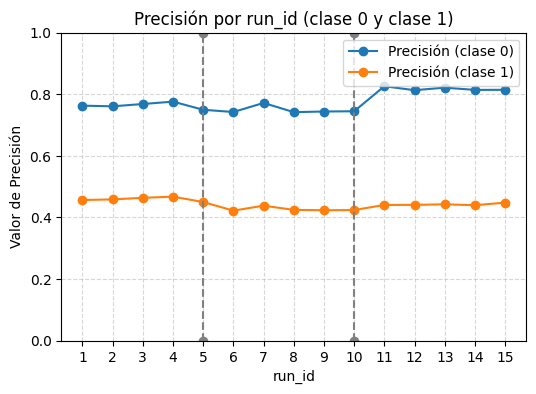

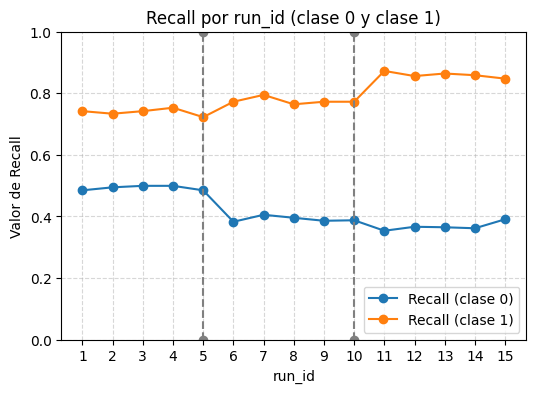

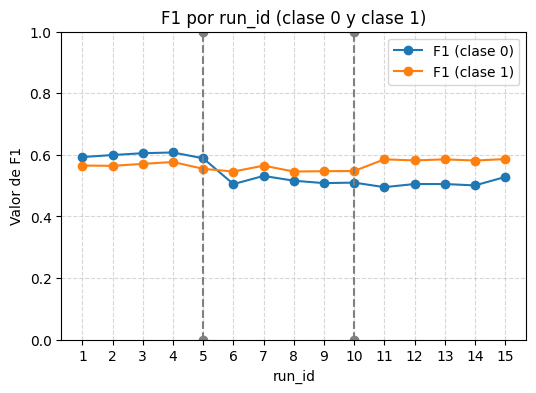

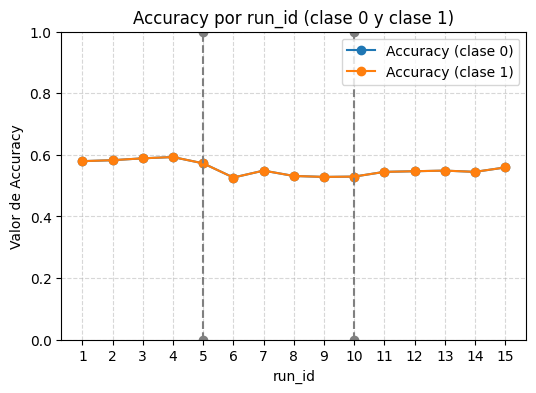

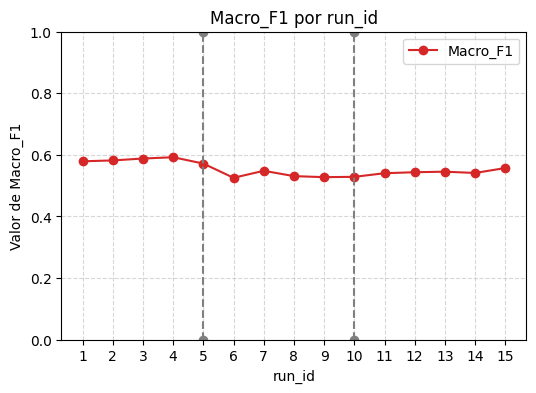

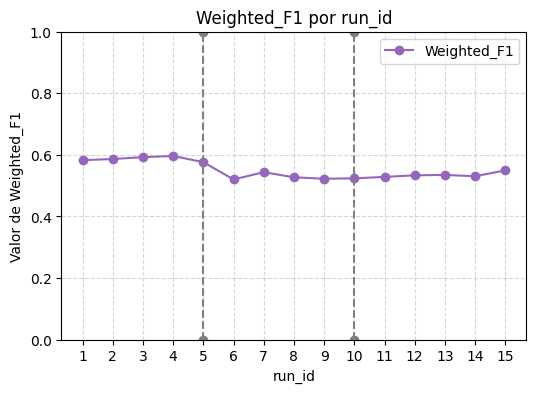

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_results.copy()

# Configuración de estilo
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["lines.marker"] = 'o'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["grid.alpha"] = 0.5

# Obtén la lista ordenada de run_id
runs = sorted(df["run_id"].unique())
color_clase = {0: "#1f77b4", 1: "#ff7f0e"}

# --------------------------------------------------------
# 1) Gráfico de PRECISIÓN (ambas clases)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run_id")
    valores = subset["precision"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Precisión (clase {clase})")

plt.title("Precisión por run_id (clase 0 y clase 1)")
plt.xlabel("run_id")
plt.ylabel("Valor de Precisión")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 2) Gráfico de RECALL (ambas clases)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run_id")
    valores = subset["recall"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Recall (clase {clase})")

plt.title("Recall por run_id (clase 0 y clase 1)")
plt.xlabel("run_id")
plt.ylabel("Valor de Recall")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 3) Gráfico de F1 (ambas clases)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run_id")
    valores = subset["f1"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"F1 (clase {clase})")

plt.title("F1 por run_id (clase 0 y clase 1)")
plt.xlabel("run_id")
plt.ylabel("Valor de F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 3) Gráfico de Accuracy (ambas clases)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run_id")
    valores = subset["accuracy"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Accuracy (clase {clase})")

plt.title("Accuracy por run_id (clase 0 y clase 1)")
plt.xlabel("run_id")
plt.ylabel("Valor de Accuracy")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 4) Gráfico de MACRO_F1 (una sola línea)
# --------------------------------------------------------
plt.figure()
macro_por_run = df.groupby("run_id")["macro_f1"].first().reset_index()
plt.plot(macro_por_run["run_id"], macro_por_run["macro_f1"], color="#d62728", label="Macro_F1")
plt.title("Macro_F1 por run_id")
plt.xlabel("run_id")
plt.ylabel("Valor de Macro_F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 5) Gráfico de WEIGHTED_F1 (una sola línea)
# --------------------------------------------------------
plt.figure()
weighted_por_run = df.groupby("run_id")["weighted_f1"].first().reset_index()
plt.plot(weighted_por_run["run_id"], weighted_por_run["weighted_f1"], color="#9467bd", label="Weighted_F1")
plt.title("Weighted_F1 por run_id")
plt.xlabel("run_id")
plt.ylabel("Valor de Weighted_F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()



## **FIN EXPERIMENTOS MHIST**
